# Preferential Bayesian Optimization: Predictive Entropy Search
This notebook demonstrates the use of the Predictive Entropy Search (PES) acquisition function on ordinal (preference) data, and compares its performance directly to the Dueling-Thompson sampling acquisition function by Gonzalez et al (2017). 

We conduct experiments over simple 1-dimensional values in the domain [0, 1] and define the following preference ordering over them: given the Forrester function f (1-dimensional test function by Forrester et al. (2008)), and two inputs a and b, a > b if f(a) < f(b).

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
objective = PBO.objectives.forrester
objective_low = 0.
objective_high = 1.
objective_name = "Forrester"
acquisition_name = "PES"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name

In [3]:
num_runs = 2
num_evals = 2
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 3
num_inducing_init = 3
num_discrete_per_dim = 10000 # Discretization of continuous input space

In [4]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  C:\Users\seb\Desktop\FYP\PBO\notebooks\PES/results/PBO_PES_Forrester/  already exists


Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

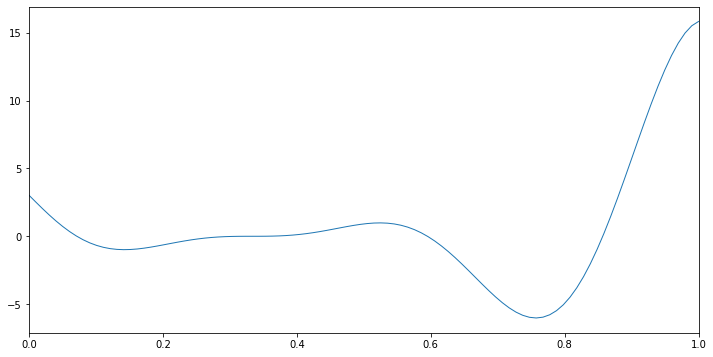

In [5]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, objective(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [6]:
def plot_gp(model, X, y, title):
    if input_dims == 1:
        #Plotting code from GPflow authors

        ## generate test points for prediction
        xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

        ## predict mean and variance of latent GP at test points
        mean, var = model.predict_f(xx)

        ## generate 10 samples from posterior
        samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

        ## plot 
        plt.figure(figsize=(12, 6))
        plt.plot(X, y, 'kx', mew=2)
        plt.plot(xx, mean, 'C0', lw=2)
        plt.fill_between(xx[:,0],
                         mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                         mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                         color='C0', alpha=0.2)

        plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
        plt.xlim(-0.1, 1.1)
        plt.title(title)

        plt.savefig(fname=results_dir + title + ".png")
        
    elif input_dims == 2:
        side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
        X,Y = np.meshgrid(side,side)
        combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
        predictions = m.predict_y(combs)
        preds = tf.transpose(tf.reshape(predictions[0], [num_discrete_per_dim, num_discrete_per_dim]))
        variances = tf.transpose(tf.reshape(predictions[1], [num_discrete_per_dim, num_discrete_per_dim]))

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(title)
        fig.set_size_inches(18.5, 6.88)
        fig.set_dpi((200))

        ax1.axis('equal')
        im1 = ax1.imshow(preds, 
                         interpolation='nearest', 
                         extent=(objective_low, objective_high, objective_low, objective_high), 
                         origin='lower', 
                         cmap=cmap)
        ax1.set_title("Mean")
        ax1.set_xlabel("x0")
        ax1.set_ylabel("x1")
        fig.colorbar(im1, ax=ax1)

        ax2.axis('equal')
        im2 = ax2.imshow(variances, 
                         interpolation='nearest', 
                         extent=(objective_low, objective_high, objective_low, objective_high), 
                         origin='lower', 
                         cmap=cmap)
        ax2.set_title("Variance")
        ax2.set_xlabel("x0")
        ax2.set_ylabel("x1")
        fig.colorbar(im2, ax=ax2)

        plt.savefig(fname=results_dir + title + ".png")
        plt.show()
    
    else:
        print("Cannot plot function with more than 2 dimensions")

In [25]:
def train_and_visualize(X, y, num_inducing, title):
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k = PBO.models.learning_stochastic.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         num_steps=2500)
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, u_mean, title)
    
    return model, inputs, u_mean, inducing_vars

In [8]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [9]:
def best_guess(model):
    """
    Returns a GP model's best guess of the global maximum of f.
    """
    xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

In [10]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

Store the results in these arrays:

In [11]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [12]:
np.random.seed(0)
init_points = np.random.uniform(size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

In [ ]:
# Test code
X = np.array([[[2.2, 0.3],
               [0.4, 0.5]],
              [[-1.7, 0.3],
              [0.4, 0.9]]])

f = objectives.objective_get_f_neg(X, objectives.six_hump_camel)
y = observation_model.gen_observation_from_f(X, f, 1)
q_mu, q_sqrt, u, inputs, k = train_model_fullcov(X, y,
                                                 num_inducing=2,
                                                 obj_low=-2.,
                                                 obj_high=2.,
                                                 lengthscale=1.,
                                                 num_steps=2500)

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

Beginning run 0
Negative ELBO at step 0: 8.57265105584233
Negative ELBO at step 500: 7.736259574279369
Negative ELBO at step 1000: 7.4407251998143416
Negative ELBO at step 1500: 7.322965807026836
Beginning evaluation 0
Evaluation 0: Sampling maximizers
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Loss at step 0: -0.9635747096751088
tf.Tensor(
[[0.48352671]
 [0.29273078]
 [0.32707287]
 [0.79233669]
 [0.78214776]
 [0.77550794]
 [0.25413457]
 [0.67117028]
 [0.77157678]
 [0.2083501 ]
 [0.82838781]
 [0.37446039]
 [0.37975769]
 [0.4429794 ]
 [0.70333031]
 [0.05885782]
 [0.51477762]
 [0.61245544]
 [0.50918964]
 [0.73678081]], shape=(20, 1), dtype=float64)
Evaluation 0: Calculating I
Evaluation 0: Next query is tf.Tensor(
[[0.71518937]
 [0.24442559]], shape=(2, 1), dtype=float64) with I value of 0.08957564482317872
Evaluation 0: Training model
Negative ELBO at step 0

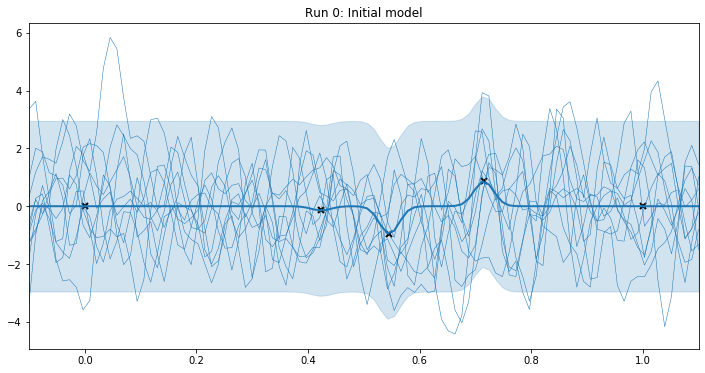

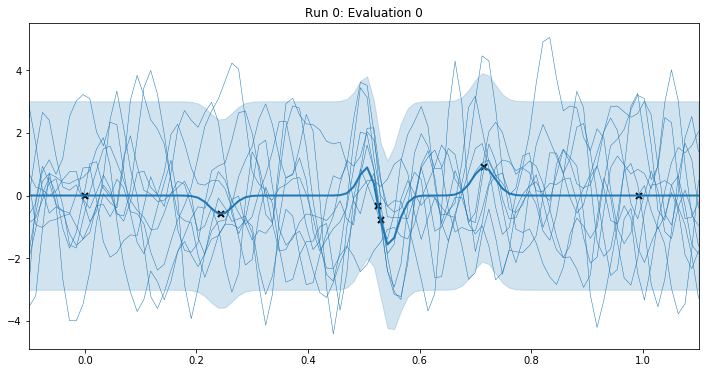

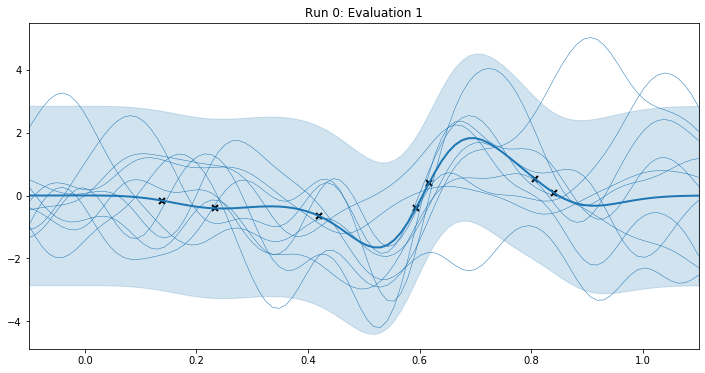

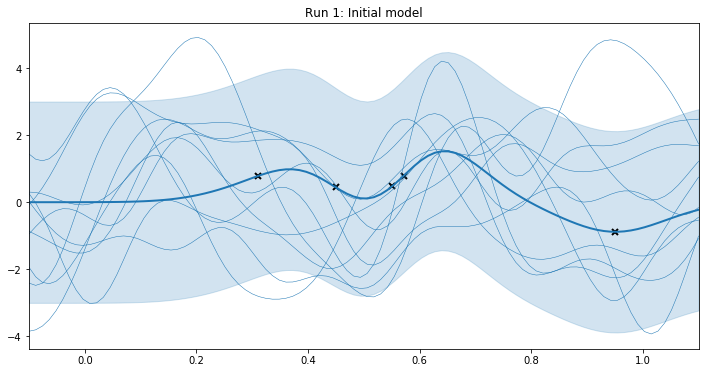

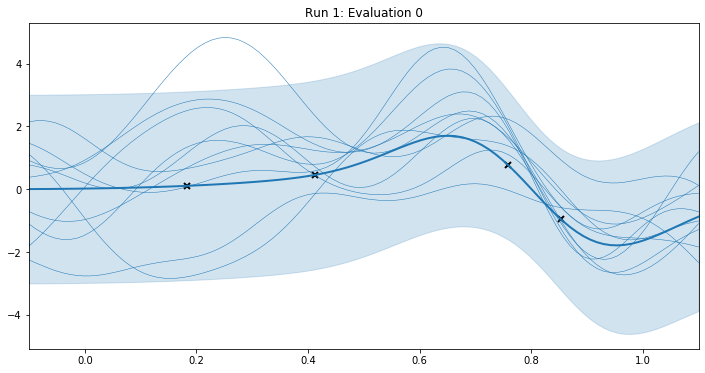

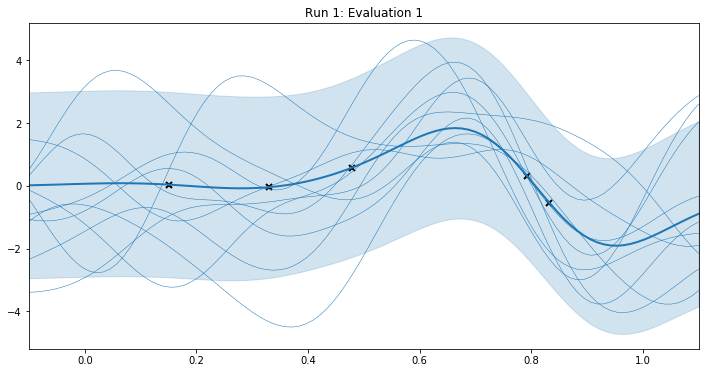

In [19]:
for run in range(num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run_{}:_Initial_model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Sample possible next queries
        
        samples = PBO.acquisitions.pes.sample_inputs(inputs, num_samples, num_choices)

        # Sample maximizers
        print("Evaluation %s: Sampling maximizers" % (evaluation))
        maximizers = PBO.fourier_features.sample_maximizers(X=inducing_vars,
                                                            count=num_maximizers,
                                                            n_init=10,
                                                            D=100,
                                                            model=model)
        print(maximizers)

        # Calculate PES value I for each possible next query
        print("Evaluation %s: Calculating I" % (evaluation))
        I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model)

        # Select query that maximizes I
        next_idx = np.argmax(I_vals)
        next_query = samples[next_idx]
        print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = get_noisy_observation(X, objective)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   num_inducing_init + evaluation + 1, 
                                                                   "Run_{}:_Evaluation_{}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

In [27]:
pickle.dump((X_results, y_results, best_guess_results), open("results/PBO_PES_Binary_FullCov_results.p", "wb"))

ValueError: x and y must have same first dimension, but have shapes (20,) and (2, 1)

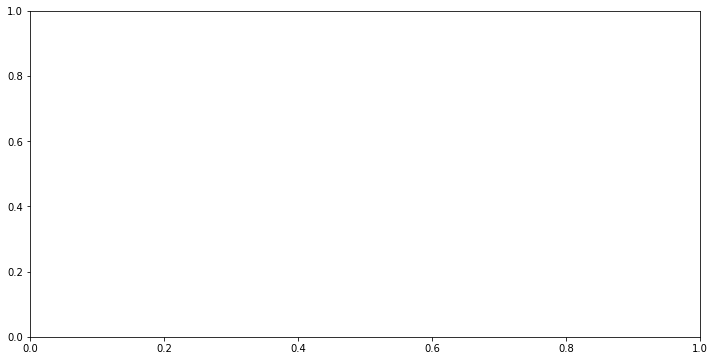

In [20]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = abs(best_guess_results[i] - global_min)
    
    x_axis = list(range(11, 31))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess error', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()